In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from scipy.sparse import coo_matrix
from numba import jit, prange

# Prepare data

## Sparse matrix

In [2]:
ds = xr.open_dataset("weights.nc")
ds

<xarray.Dataset>
Dimensions:  (n_s: 480000)
Dimensions without coordinates: n_s
Data variables:
    S        (n_s) float64 ...
    col      (n_s) int32 ...
    row      (n_s) int32 ...

In [3]:
n_s = ds.dims['n_s']
col = ds['col'].values - 1
row = ds['row'].values - 1
S = ds['S'].values

In [4]:
A = coo_matrix((S, (row, col))) 
A.shape

(120000, 240000)

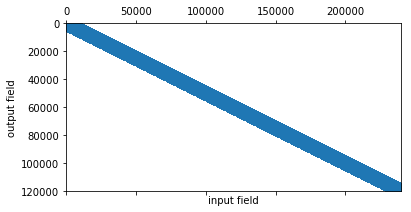

In [5]:
plt.spy(A)
plt.xlabel('input field')
plt.ylabel('output field')

## Data

In [6]:
data = np.random.rand(500, A.shape[1])
data.shape

(500, 240000)

In [7]:
# placeholder 
data_out = np.zeros([data.shape[0], A.shape[0]])
data_out.shape

(500, 120000)

# scipy.sparse dot


## Common memory order

In [8]:
A_csc = A.tocsc()
A_csr = A.tocsr()

In [9]:
out_scipy = A.dot(data.T).T  # for later reference
out_scipy.shape

(500, 120000)

In [10]:
%timeit A.dot(data.T).T
%timeit A_csc.dot(data.T).T
%timeit A_csr.dot(data.T).T

560 ms ± 17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.05 s ± 20.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.04 s ± 19.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
data.T.flags

  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False

## Reversed memory order

In [12]:
data_T = data.T.copy()

In [13]:
data_T.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False

In [14]:
%timeit A.dot(data_T).T
%timeit A_csc.dot(data_T).T
%timeit A_csr.dot(data_T).T

3.14 s ± 59.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
392 ms ± 23.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
443 ms ± 37.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# numba

## Serial

In [15]:
@jit(nopython=True)
def sparse_dot(data_out, data, col, row, S):
    data_out[...] = 0.0
    for j in range(data.shape[0]):
        for i in range(S.size):
            data_out[j, row[i]] += data[j, col[i]]*S[i]

sparse_dot(data_out, data, col, row, S); # compile jit

In [16]:
np.array_equal(data_out, out_scipy)

True

In [17]:
%timeit sparse_dot(data_out, data, col, row, S)

451 ms ± 14.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## parallel

In [18]:
@jit(nopython=True, parallel=True)
def sparse_dot_parallel(data_out, data, col, row, S):
    for j in prange(data.shape[0]):
        data_out[j, :] = 0.0
        for i in range(S.size):
            data_out[j, row[i]] += data[j, col[i]]*S[i]

sparse_dot_parallel(data_out, data, col, row, S); # compile jit

In [19]:
np.array_equal(data_out, out_scipy)

True

In [20]:
%timeit sparse_dot_parallel(data_out, data, col, row, S)

214 ms ± 9.62 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Cython

In [21]:
%load_ext Cython

In [22]:
%%cython -a
cimport cython

@cython.boundscheck(False)
cpdef cython_dot(double[:, :] data_out, double[:, :] data, 
                 int[:] col, int[:] row, double[:] S):
    cdef int i, j 
    data_out[...] = 0.0
    for j in range(data.shape[0]):
        for i in range(S.shape[0]):
            data_out[j, row[i]] += data[j, col[i]]*S[i]

In [23]:
cython_dot(data_out, data, col, row, S)
np.array_equal(data_out, out_scipy)

True

In [24]:
%timeit cython_dot(data_out, data, col, row, S)

813 ms ± 38.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
